# Question No.2
 NLP Dataset: Sentiment Analysis dataset - 1.6 Million tweets. Please find your dataset https://www.kaggle.com/kazanova/sentiment140. The column 'text' has the tweet and 'target' gives the sentiment of the text.

 Prepare a python notebook (recommended- use Google Colab) to build, train and evaluate a deep neural network on the given dataset. Read the instructions carefully.

#1. Import Libraries/Dataset

a. Import required libraries (recommended- use tensorflow/keras library).

b. Import the dataset (use Google Drive if required).

c. Check the GPU available (recommended- use free GPU provided by Google Colab).

In [ ]:
import numpy as np
import pandas as pd

from tensorflow.keras import models
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer


import gensim

import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools
import tarfile

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Load the Drive helper and mount
from google.colab import drive 
# This will prompt for authorization.
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My\ Drive

/content/gdrive/My Drive


In [ ]:
!ls "Colab Notebooks/DL_Assignment_2"


data
training.1600000.processed.noemoticon.csv
training.1600000.processed.noemoticon.csv.zip


#2. Data Visualization 
a. Print at least two tweets from each class of the dataset, for a sanity check that labels match the text. 

b. Plot a bar graph of class distribution in dataset. Each bar depicts the number of tweets belonging to a particular sentiment. (recommended - matplotlib/seaborn libraries) 

c. Any other visualizations that seem appropriate for this problem are encouraged but not necessary, for the points.

d. Print the shapes of train and test data.

In [ ]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('./Colab Notebooks/DL_Assignment_2/data/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

dataset.head(5)

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
dataset.shape

(1600000, 6)

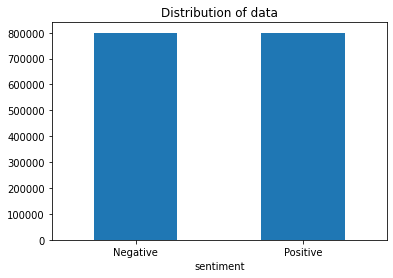

In [ ]:
# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Plotting the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

In [ ]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

#3. Data Pre-processing 
a. Need for this Step - Since the models we use cannot accept string inputs or cannot be of the string format. We have to come up with a way of handling this step. The discussion of different ways of handling this step is out of the scope of this assignment.

b. Please use this pre-trained embedding layer ( https://tfhub.dev/google/nnlm-en-dim128/1 ) from TensorFlow hub for this assignment. This link also has a code snippet on how to convert a sentence to a vector. Refer to that for further clarity on this subject.

c. Bring the train and test data in the required format.

In [ ]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [ ]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [ ]:
nltk.download('wordnet')

import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
Text Preprocessing complete.
Time Taken: 102 seconds


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.5, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [ ]:
print("training data input :"+str(len(X_train)))
print("training data output :"+str(len(y_train)))

print("Test data input :"+str(len(X_test)))
print("Test data output :"+str(len(y_test)))

training data input :800000
training data output :800000
Test data input :800000
Test data output :800000


In [ ]:
train_examples_batch = next(iter(X_train[1:10]))
train_examples_batch
#np.array(train_examples_batch)

'so downed some tea and feel million time better yes '

# 4. Model Building 
a. Sequential Model layers- Use AT LEAST 3 dense layers with appropriate input for each. Choose the best number for hidden units and give reasons.

b. Add L2 regularization to all the layers.

c. Add one layer of dropout at the appropriate position and give reasons.

d. Choose the appropriate activation function for all the layers.

e. Print the model summary.

In [ ]:
#!pip install --upgrade keras
import tensorflow as tf
import tensorflow_hub as hub
import keras
from keras.layers import Dropout, Dense
from tensorflow.keras import regularizers


hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/1",input_shape=[], dtype=tf.string)

'''model = keras.Sequential()
model.add(hub_layer)
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))'''

'''tf.keras.layers.Dense(100, activation='tanh',kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l2(0.01)),'''

baseline_model = keras.Sequential()
baseline_model.add(hub_layer)

baseline_model.add(keras.layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l2(0.01)))
baseline_model.add(keras.layers.Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l2(0.01)))
baseline_model.add(keras.layers.Dropout(0.5))
baseline_model.add(keras.layers.Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l2(0.01)))

baseline_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               249285376 
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 249,294,689
Trainable params: 9,313
Non-trainable params: 249,285,376
_________________________________________________________________


<b>
 <li>A base line model is built 3 Dense layers and L2 regularization at each layer</li>
 <li> The model is built with a dropout of 0.5 to compare with the other models</li>
 <li> Relu Activation function is chosen for hidden layers while sigmoid function is chosen at the output layer </li>
</b>

# 5. Model Compilation 

a. Compile the model with the appropriate loss function.

b. Use an appropriate optimizer. Give reasons for the choice of learning rate and its value.

c. Use accuracy as metric.

In [ ]:
baseline_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


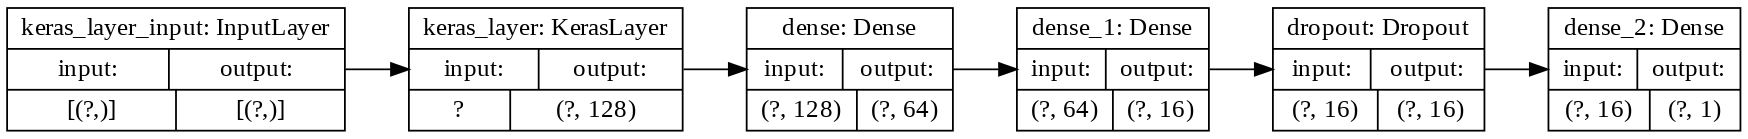

In [ ]:
keras.utils.plot_model(baseline_model, 
                      to_file='baseline_model.png',
                      show_shapes=True, show_layer_names=True, rankdir='LR', expand_nested=False, dpi=128)

#6. Model Training 

a. Train the model for an appropriate number of epochs (print the train and validation accuracy/loss for each epoch). Use the appropriate batch size.

b. Plot the loss and accuracy history graphs. Print the total time taken for training.

In [ ]:
import time

start_time = time.time() 
print('\n')
hist = baseline_model.fit(X_train, 
                 y_train, 
                 epochs=5,batch_size=40000,
                 validation_data=(X_test,y_test),
                 verbose = 1)
print("--- Time took for trainig is %s seconds ---" % (time.time() - start_time))

# Benchmark time: 6 min per 25 epochs for 80 000 records/batch 32
# Benchmark time: 2 min per 30 epochs for 80 000 records/64 nodes/batch 64
# Benchmark time: 2.5  min per 30 epochs for 150 000 records/128 nodes/batch 128



Epoch 1/5
20/20 [==============================] - 11s 570ms/step - loss: 0.9711 - accuracy: 0.5049 - val_loss: 0.8147 - val_accuracy: 0.5073
Epoch 2/5
20/20 [==============================] - 4s 204ms/step - loss: 0.6980 - accuracy: 0.4988 - val_loss: 0.5816 - val_accuracy: 0.5005
Epoch 3/5
20/20 [==============================] - 4s 204ms/step - loss: 0.4968 - accuracy: 0.5003 - val_loss: 0.4127 - val_accuracy: 0.4997
Epoch 4/5
20/20 [==============================] - 4s 204ms/step - loss: 0.3518 - accuracy: 0.5003 - val_loss: 0.2916 - val_accuracy: 0.4997
Epoch 5/5
20/20 [==============================] - 4s 205ms/step - loss: 0.2482 - accuracy: 0.5003 - val_loss: 0.2054 - val_accuracy: 0.4997
--- Time took for trainig is 38.19131898880005 seconds ---


<function matplotlib.pyplot.show>

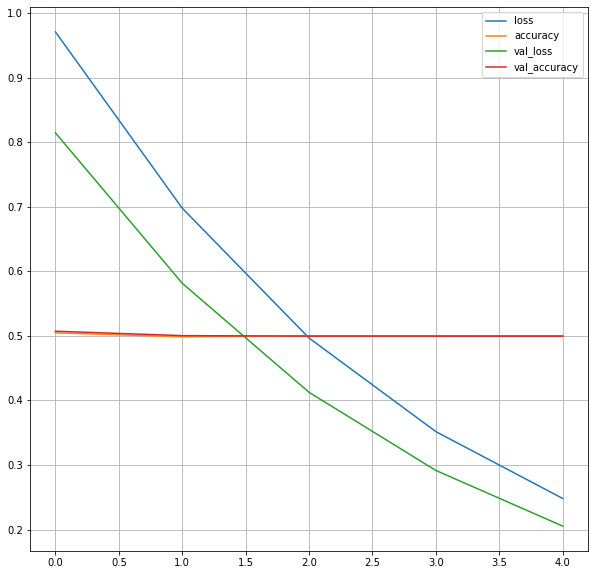

In [ ]:
pd.DataFrame(hist.history).plot(figsize=(10,10))
plt.grid(True)
plt.show

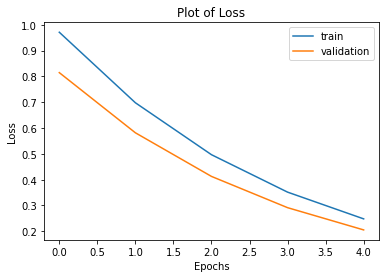

In [ ]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Plot of Loss')
plt.legend()
plt.show()

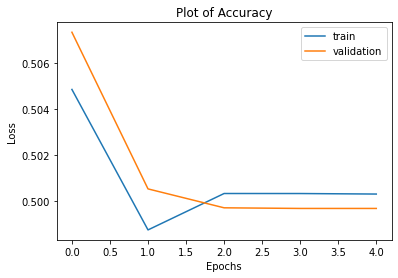

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Plot of Accuracy')
plt.legend()
plt.show()

#7. Model Evaluation 

a. Print the final test/validation loss and accuracy.

b. Print confusion matrix and classification report for the validation dataset. Write a summary for the best and worst performing class and the overall trend.

In [ ]:
print('Final training loss \t', hist.history['loss'][-1])
print('Final training accuracy ', hist.history['accuracy'][-1])

Final training loss 	 0.2481890171766281
Final training accuracy  0.5003137588500977


In [ ]:
test_Loss, test_Accuracy = baseline_model.evaluate( X_test, y_test)

25000/25000 [==============================] - 224s 9ms/step - loss: 0.2054 - accuracy: 0.4997


In [ ]:
print('Testing loss \t', test_Loss)
print('Testing accuracy ', test_Accuracy)

Testing loss 	 0.2129051685333252
Testing accuracy  0.4996887445449829


<b>
<li> The baseline model has a training loss of 25.6% and a training accuracy of 50.03% </li>
<li> The baseline model has a testing loss of 21.2% and a testing accuracy of 49.9% </li>
</b>

**Print confusion matrix and classification report for the validation dataset. Write a summary for the best and worst performing class and the overall trend.**

---



In [ ]:
def plot_confusion_matrix(cm, 
                          classes, 
                          normalize=False,
                          title='CM', 
                          cmap=plt.cm.Greens):
# This function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix") # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap) 
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes)) 
    plt.xticks(tick_marks, classes, rotation=45) 
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout() 
        plt.ylabel('True label') 
        plt.xlabel('Predicted label')

In [ ]:
y_pred = baseline_model.predict(X_train)
y_pred_rounded = np.argmax(y_pred, axis=1)

In [ ]:
cmResults = confusion_matrix(y_train, y_pred_rounded) 
accuracy = accuracy_score(y_train, y_pred_rounded)

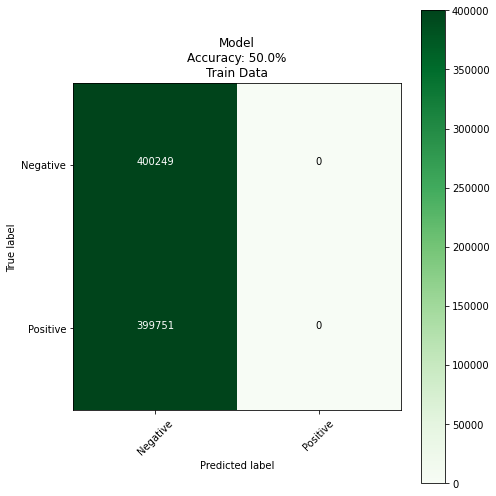

In [ ]:
class_names = ['Negative', 'Positive']
plt.figure(figsize=(7,7));
plot_confusion_matrix(cmResults, classes=class_names, title="Model"+ "\n" +"Accuracy: " + str((accuracy*100).round(1)) + "%" +"\n"+"Train Data");

In [ ]:
y_pred_test = baseline_model.predict(X_test)
y_pred_test_rounded = np.argmax(y_pred, axis=1)
cmResults = confusion_matrix(y_test, y_pred_test_rounded)
accuracy = accuracy_score(y_test, y_pred_test_rounded)

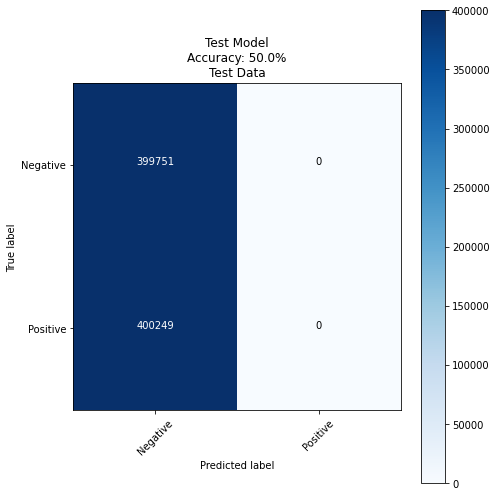

In [ ]:
plt.figure(figsize=(7,7));
plot_confusion_matrix(cmResults, classes=class_names, 
                      title="Test Model"+ "\n" +"Accuracy: " + str((accuracy*100).round(1)) + "%" +"\n"+"Test Data",
                      cmap=plt.cm.Blues);


In [ ]:
classes =  ['Negative', 'Positive']
print(classification_report(y_test, y_pred_test_rounded, target_names = classes))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    Negative       0.50      1.00      0.67    399751
    Positive       0.00      0.00      0.00    400249

    accuracy                           0.50    800000
   macro avg       0.25      0.50      0.33    800000
weighted avg       0.25      0.50      0.33    800000



# Hyperparameter Tuning- Build two more models by changing the following hyperparameters one at a time.

Write the code for Model Building, Model Compilation, Model Training and Model Evaluation as given in the instructions above for each additional model.
1. Dropout: Change the position and value of dropout layer
2. Regularization: Train a model without regularization
Write a comparison between each model and give reasons for the difference in results. Also, make a comparison with the state-of-the-art accuracy for this dataset.

In [ ]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/1",input_shape=[], dtype=tf.string)


model_1 = keras.Sequential()
model_1.add(hub_layer)

model_1.add(keras.layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l2(0.01)))
model_1.add(keras.layers.Dropout(0.25))
model_1.add(keras.layers.Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l2(0.01)))
model_1.add(keras.layers.Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l2(0.01)))

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               249285376 
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 249,294,689
Trainable params: 9,313
Non-trainable params: 249,285,376
_________________________________________________________________


<b>
<li>Model-1 is built with a dropout of 0.25 in the 1st hidden layer. </li>
<li> This model has 64 neurons in the first hidden layer and 16 in the second layer</li>

<li> Activation functions ReLu and Sigmoid are choosen at the hidden layers and the output layer respectively.
</b>

In [ ]:
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

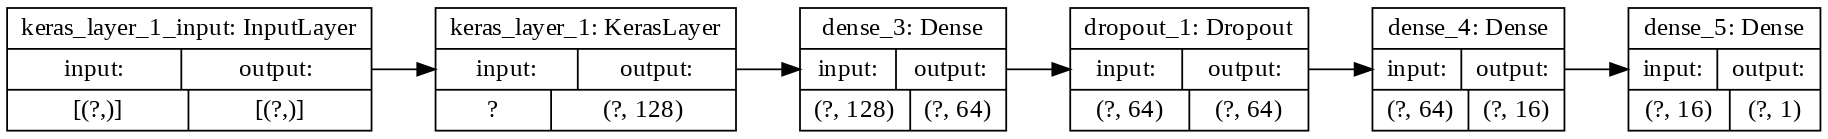

In [ ]:
keras.utils.plot_model(model_1, 
                      to_file='model_1.png',
                      show_shapes=True, show_layer_names=True, rankdir='LR', expand_nested=False, dpi=128)

In [ ]:
start_time = time.time() 
print('\n')
hist_1 = model_1.fit(X_train, 
                 y_train, 
                 epochs=5,batch_size=40000,
                 validation_data=(X_test,y_test),
                 verbose = 1)
print("--- Time taken for trainig model_1 is %s seconds ---" % (time.time() - start_time))




Epoch 1/5
20/20 [==============================] - 11s 550ms/step - loss: 0.9908 - accuracy: 0.4958 - val_loss: 0.8316 - val_accuracy: 0.4994
Epoch 2/5
20/20 [==============================] - 4s 202ms/step - loss: 0.7132 - accuracy: 0.4997 - val_loss: 0.5949 - val_accuracy: 0.4997
Epoch 3/5
20/20 [==============================] - 4s 199ms/step - loss: 0.5086 - accuracy: 0.5003 - val_loss: 0.4230 - val_accuracy: 0.4997
Epoch 4/5
20/20 [==============================] - 4s 200ms/step - loss: 0.3610 - accuracy: 0.5003 - val_loss: 0.2997 - val_accuracy: 0.4997
Epoch 5/5
20/20 [==============================] - 4s 203ms/step - loss: 0.2554 - accuracy: 0.5003 - val_loss: 0.2118 - val_accuracy: 0.4997
--- Time taken for trainig model_1 is 35.39108657836914 seconds ---


<function matplotlib.pyplot.show>

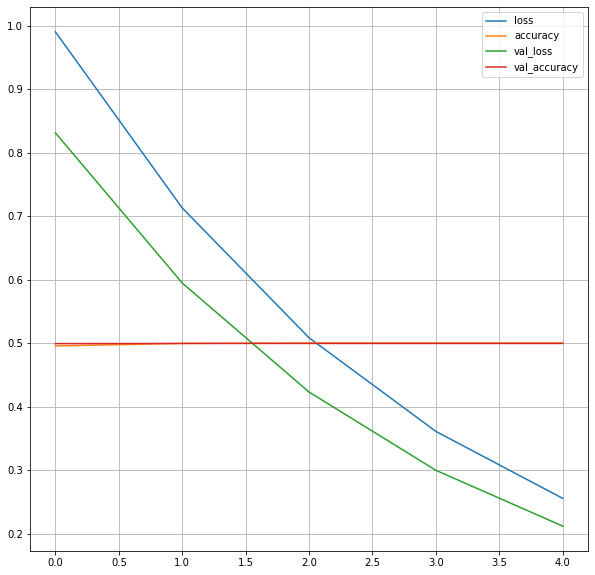

In [ ]:
pd.DataFrame(hist_1.history).plot(figsize=(10,10))
plt.grid(True)
plt.show

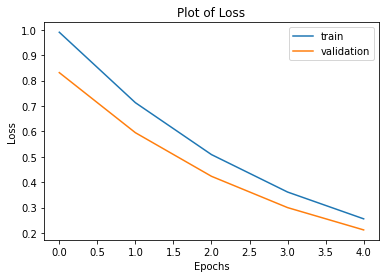

In [ ]:
plt.plot(hist_1.history['loss'], label='train')
plt.plot(hist_1.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Plot of Loss')
plt.legend()
plt.show()

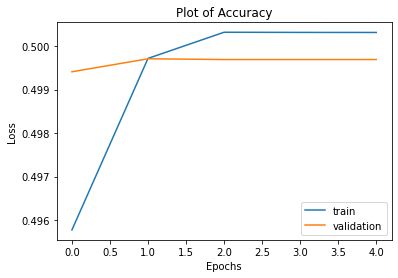

In [ ]:

plt.plot(hist_1.history['accuracy'], label='train')
plt.plot(hist_1.history['val_accuracy'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Plot of Accuracy')
plt.legend()
plt.show()

In [ ]:
print('Final training loss \t', hist_1.history['loss'][-1])
print('Final training accuracy ', hist_1.history['accuracy'][-1])

Final training loss 	 0.25544679164886475
Final training accuracy  0.5003112554550171


In [ ]:
test_Loss_1, test_Accuracy_1 = model_1.evaluate( X_test, y_test)

25000/25000 [==============================] - 217s 9ms/step - loss: 0.2118 - accuracy: 0.4997


In [ ]:
print('Testing loss \t', test_Loss_1)
print('Testing accuracy ', test_Accuracy_1)

Testing loss 	 0.21177256107330322
Testing accuracy  0.4996887445449829


<b> 
<li> Model-1 has a training accuracy of 50.03% and a trainng loss of 25.5% </li>
<li> Model-1 has a testing accuracy of 49.9% and a testing loss of 21.1% </li>
</b>

***
<b>Model with no regularizers </b>
***

In [ ]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/1",input_shape=[], dtype=tf.string)


model_2 = keras.Sequential()
model_2.add(hub_layer)

model_2.add(keras.layers.Dense(64, activation='relu'))
model_2.add(keras.layers.Dense(16, activation='relu'))
model_2.add(keras.layers.Dropout(0.5))
model_2.add(keras.layers.Dense(1, activation='sigmoid'))

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 128)               249285376 
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 249,294,689
Trainable params: 9,313
Non-trainable params: 249,285,376
_________________________________________________________________


<b>
<li> A model-2 is built with no regularizers </li>
<li> This model has a drop out of 0.5 at the second hidden layer </li>
<li> The model has 64 and 16 neruons in the fist and the second hidden layers respectively. </li>
<li> Activation fuctions chosen are ReLu and Sigmoid at the hidden layers and the output layer respectively </li>
</b>

In [ ]:
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

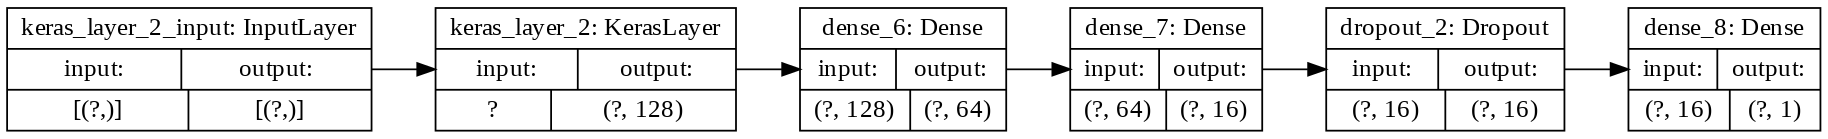

In [ ]:
keras.utils.plot_model(model_2, 
                      to_file='model_2.png',
                      show_shapes=True, show_layer_names=True, rankdir='LR', expand_nested=False, dpi=128)

In [ ]:
start_time = time.time() 
print('\n')
hist_2 = model_2.fit(X_train, 
                 y_train, 
                 epochs=5,batch_size=40000,
                 validation_data=(X_test,y_test),
                 verbose = 1)
print("--- Time taken for trainig model_1 is %s seconds ---" % (time.time() - start_time))




Epoch 1/5
20/20 [==============================] - 11s 550ms/step - loss: 5.9568e-08 - accuracy: 0.4994 - val_loss: 5.9642e-08 - val_accuracy: 0.4985
Epoch 2/5
20/20 [==============================] - 4s 206ms/step - loss: 5.9568e-08 - accuracy: 0.4994 - val_loss: 5.9642e-08 - val_accuracy: 0.4985
Epoch 3/5
20/20 [==============================] - 4s 209ms/step - loss: 5.9568e-08 - accuracy: 0.4996 - val_loss: 5.9642e-08 - val_accuracy: 0.4985
Epoch 4/5
20/20 [==============================] - 4s 202ms/step - loss: 5.9568e-08 - accuracy: 0.4993 - val_loss: 5.9642e-08 - val_accuracy: 0.4985
Epoch 5/5
20/20 [==============================] - 4s 200ms/step - loss: 5.9568e-08 - accuracy: 0.4991 - val_loss: 5.9642e-08 - val_accuracy: 0.4985
--- Time taken for trainig model_1 is 35.53082799911499 seconds ---


<function matplotlib.pyplot.show>

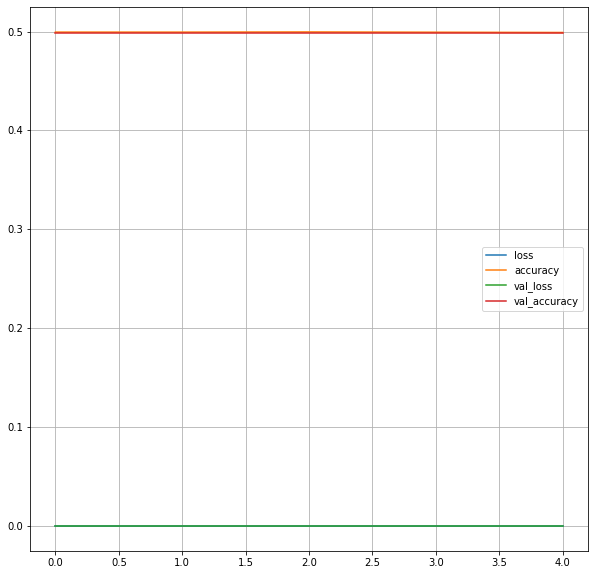

In [ ]:
pd.DataFrame(hist_2.history).plot(figsize=(10,10))
plt.grid(True)
plt.show

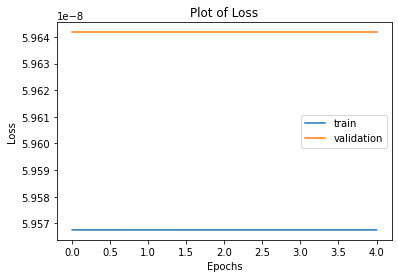

In [ ]:
plt.plot(hist_2.history['loss'], label='train')
plt.plot(hist_2.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Plot of Loss')
plt.legend()
plt.show()

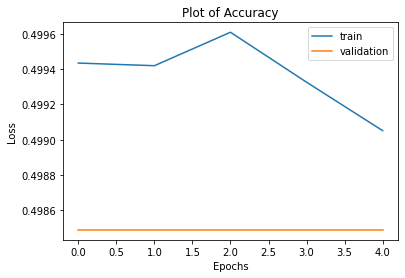

In [ ]:
plt.plot(hist_2.history['accuracy'], label='train')
plt.plot(hist_2.history['val_accuracy'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Plot of Accuracy')
plt.legend()
plt.show()

In [ ]:
print('Final training loss \t', hist_2.history['loss'][-1])
print('Final training accuracy ', hist_2.history['accuracy'][-1])

Final training loss 	 5.956754378644291e-08
Final training accuracy  0.4990512430667877


In [ ]:
test_Loss_2, test_Accuracy_2 = model_2.evaluate( X_test, y_test)

25000/25000 [==============================] - 210s 8ms/step - loss: 5.9642e-08 - accuracy: 0.4985


In [ ]:
print('Testing loss \t', test_Loss_2)
print('Testing accuracy ', test_Accuracy_2)

Testing loss 	 5.964175642247938e-08
Testing accuracy  0.4984875023365021


<b>
<li> Model-2 has a training accuracy of 49.84% and a training loss of 5.96e-08 </li>
<li> Model-2 has a testing accuracy of 50.04% and a testing loss of 5.9e-08 </li>
</b>

**Also, make a comparison with the state-of-the-art accuracy for this dataset.**

<b>
<li> A state of the art model with 128 neurons each in the first and second hidden layers is choosen. </li>
<li> The activation function Sigmoid is chosen at the output layer while keeping the activation fuction ReLu in the hidden layers. </li>
</b>

In [ ]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/1",output_shape=[128], input_shape=[], dtype=tf.string)

soa_model = keras.Sequential()
soa_model.add(hub_layer)

soa_model.add(keras.layers.Dense(128, activation='relu'))
soa_model.add(keras.layers.Dense(128, activation='relu'))
soa_model.add(keras.layers.Dense(1, activation='sigmoid'))

soa_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 128)               249285376 
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 249,318,529
Trainable params: 33,153
Non-trainable params: 249,285,376
_________________________________________________________________


In [ ]:
soa_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

start_time = time.time() 
print('\n')
hist_soa = soa_model.fit(X_train, 
                 y_train, 
                 epochs=20,batch_size=40000,
                 validation_data=(X_test,y_test),
                 verbose = 1)
print("--- Time taken for trainig model_1 is %s seconds ---" % (time.time() - start_time))




Epoch 1/20
20/20 [==============================] - 11s 543ms/step - loss: 5.9568e-08 - accuracy: 0.4942 - val_loss: 5.9642e-08 - val_accuracy: 0.4949
Epoch 2/20
20/20 [==============================] - 4s 205ms/step - loss: 5.9568e-08 - accuracy: 0.4942 - val_loss: 5.9642e-08 - val_accuracy: 0.4949
Epoch 3/20
20/20 [==============================] - 4s 204ms/step - loss: 5.9568e-08 - accuracy: 0.4942 - val_loss: 5.9642e-08 - val_accuracy: 0.4949
Epoch 4/20
20/20 [==============================] - 4s 205ms/step - loss: 5.9568e-08 - accuracy: 0.4942 - val_loss: 5.9642e-08 - val_accuracy: 0.4949
Epoch 5/20
20/20 [==============================] - 4s 206ms/step - loss: 5.9568e-08 - accuracy: 0.4942 - val_loss: 5.9642e-08 - val_accuracy: 0.4949
Epoch 6/20
20/20 [==============================] - 4s 205ms/step - loss: 5.9568e-08 - accuracy: 0.4942 - val_loss: 5.9642e-08 - val_accuracy: 0.4949
Epoch 7/20
20/20 [==============================] - 4s 209ms/step - loss: 5.9568e-08 - accuracy: 

<function matplotlib.pyplot.show>

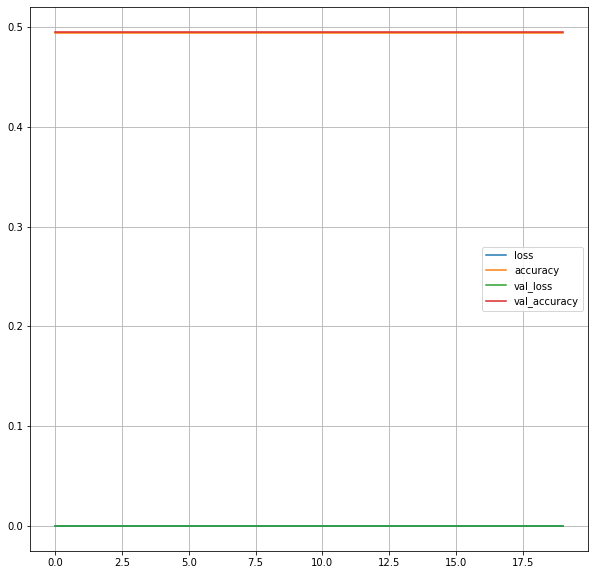

In [ ]:
pd.DataFrame(hist_soa.history).plot(figsize=(10,10))
plt.grid(True)
plt.show

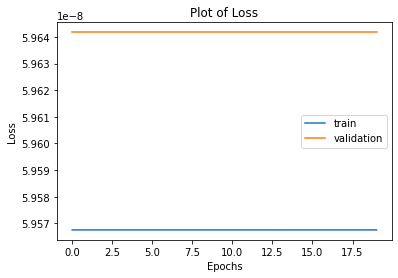

In [ ]:
plt.plot(hist_soa.history['loss'], label='train')
plt.plot(hist_soa.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Plot of Loss')
plt.legend()
plt.show()

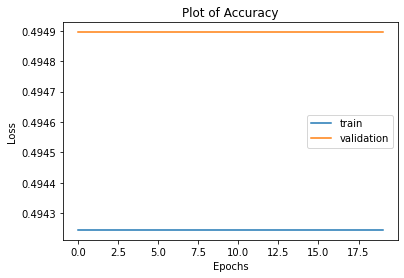

In [ ]:
plt.plot(hist_soa.history['accuracy'], label='train')
plt.plot(hist_soa.history['val_accuracy'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Plot of Accuracy')
plt.legend()
plt.show()

In [ ]:
print('Final training loss \t', hist_soa.history['loss'][-1])
print('Final training accuracy ', hist_soa.history['accuracy'][-1])

Final training loss 	 5.956754378644291e-08
Final training accuracy  0.4942449927330017


In [ ]:
test_Loss_soa, test_Accuracy_soa = model_2.evaluate( X_test, y_test)

25000/25000 [==============================] - 211s 8ms/step - loss: 5.9642e-08 - accuracy: 0.4985


In [ ]:
print('Testing loss \t', test_Loss_soa)
print('Testing accuracy ', test_Accuracy_soa)

Testing loss 	 5.964175642247938e-08
Testing accuracy  0.4984875023365021


<b>
<li> The state of the art model has a training accuracy of 49.96% with a training loss of 5.95e-08 </li>
 <li> The state of the art model has a testing accuracy of 49.84% with a testing loss of 5.96e-08 </li>
 <li> The model is trained for 20 epochs </li>

</b>